<a href="https://colab.research.google.com/github/CIMBIBOY/FungiCLEF2024_ADC/blob/cimbi/caformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import time

import torchvision
import torch.nn.functional as F
import torch
from torch import nn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import Subset
from torch.utils.data import DataLoader

import timm
import seaborn as sns
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def process(img, crop_s = 16, interp_mode = "bilinear", out_size = [300, 225]):
    img = img.transpose(1, 0, 2)
    # print(f"Input shape: {img.shape}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is not None:
        # Crop
        cropped_img = crop(img, crop_s)

        # Interpolation
        scale_factor = 300 / cropped_img.shape[0]
        sigma = scale_factor * 0.5
        cropped_img = interpolate(cropped_img, 5, sigma, int_mode = interp_mode, size = out_size)
        cropped_img = cropped_img.transpose(1, 2, 0)

        # Retransform
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
        cropped_img = cropped_img.transpose(1, 0, 2)

        # Adding to array for saving as .npy
        # print(f"Output shape: {cropped_img.shape}")
        return np.array(cropped_img)

def crop(img, crop_s = 16):
    w, h, c = img.shape

    # Crop x pixels from the top and bottom
    if h > 270:
        img = img[:, crop_s:h - crop_s, :]
    #print(img.shape)
    return img

def interpolate(img, kernel_size = 5, sigma = 0.1, int_mode = "bilinear", size = [300, 225]):
    img = torch.tensor(img)
    # Blur for noise reduc
    blur = torchvision.transforms.GaussianBlur(kernel_size, sigma)
    blured_img = blur(img)
    blured_img = blured_img.transpose(0, 2)
    blured_img = blured_img.transpose(1, 2)
    # print(blured_img.shape)
    interpolated_img = F.interpolate(blured_img.unsqueeze(0), size, mode= int_mode)
    interpolated_img = interpolated_img.squeeze(0)
    # print(interpolated_img.shape)
    return interpolated_img.detach().numpy()

def downsample(data):
    d1 = cv2.pyrDown(data)
    d2 = cv2.pyrDown(d1)
    # d3 = cv2.pyrDown(d2)
    print("Original shape: ", data.shape, "Downsampled shape: ", d2.shape)
    return np.array(d2)

def upsample(data):
    d1 = cv2.pyrUp(data)
    d2 = cv2.pyrUp(d1)
    # d3 = cv2.pyrDown(d2)
    print("Original shape: ", data.shape, "Downsampled shape: ", d2.shape)
    return np.array(d2)


def fungi_collate_fn(batch):
    images, class_ids, toxicities, img_names = [], [], [], []
    for image, (class_id, toxicity), img_name in batch:
        # print(f"Individual image shape: {image.shape}")  # Should be [C, H, W]
        images.append(image)
        class_ids.append(class_id)
        toxicities.append(toxicity)
        img_names.append(img_name)

    images = torch.stack(images)  # Should result in shape [batch_size, C, H, W]
    #print(f"Batch images shape after stacking: {images.shape}")

    class_ids = torch.tensor(class_ids, dtype=torch.long)
    toxicities = torch.tensor(toxicities, dtype=torch.long)

    return images, (class_ids, toxicities), img_names

In [4]:
class FungiDataset(Dataset):
    def __init__(self, image_dir, labels_path, pre_load=True, crop_height=16, interpolate="bilinear", out_size=(300, 225), transform=None, class_ids_to_include=None):
        '''
        Args:
            image_dir: directory containing the images
            labels_path: path to the labels CSV file
            pre_load: True if images should be loaded into memory, False otherwise
            crop_height: Height for cropping images
            interpolate: Interpolation method
            out_size: Output size for resized images
            transform: Optional transform to be applied on a sample.
        '''
        self.image_dir = image_dir
        self.labels_path = labels_path
        self.pre_load = pre_load
        self.crop_h = crop_height
        self.interpolate = interpolate
        self.out_size = out_size
        self.transform = transform
        self.load_num = 0

        # Load metadata
        metadata = pd.read_csv(self.labels_path)

        # Filter to include only existing imgs
        image_files = set(os.listdir(self.image_dir))
        metadata = metadata[metadata['image_path'].isin(image_files)]

        if metadata.empty:
            raise ValueError('No matching images found in the image directory')

        # **Filter to include only specified class IDs**
        if class_ids_to_include is not None:
            metadata = metadata[metadata['class_id'].isin(class_ids_to_include)]
            metadata.reset_index(drop=True, inplace=True)

        # Reset index after filtering
        metadata.reset_index(drop=True, inplace=True)

        # Ensure labels are integers
        metadata['class_id'] = metadata['class_id'].astype(int)
        metadata['poisonous'] = metadata['poisonous'].astype(int)

        # **Remap class IDs to a continuous range starting from 0**
        unique_class_ids = sorted(metadata['class_id'].unique())
        class_id_to_idx = {original_id: idx for idx, original_id in enumerate(unique_class_ids)}
        metadata['class_id'] = metadata['class_id'].map(class_id_to_idx)

        # Update class IDs and calculate the number of species classes
        self.metadata = metadata
        self.image_paths = metadata['image_path'].tolist()
        self.class_ids = metadata['class_id'].tolist()
        self.toxicities = metadata['poisonous'].tolist()
        self.num_species_classes = len(unique_class_ids)

        # Pre-load images if required
        if self.pre_load:
            self.images = []
            for img_name in self.image_paths:
                img_path = os.path.join(self.image_dir, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Image {img_path} could not be read.")
                    continue

                img_processed = process(img, crop_s=self.crop_h, interp_mode=self.interpolate, out_size=self.out_size)
                # Convert image to tensor and float32
                image = torch.from_numpy(img_processed).float()
                image = image.permute(2, 0, 1)

                # Normalize using ImageNet mean and std
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                image = (image - mean) / std
                self.images.append(image)
                self.load_num += 1
                if self.load_num / 3 == 0:
                  print(f"{self.load_num / 1000} images loaded")
        else:
            self.images = None  # Images will be loaded in __getitem__

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if self.pre_load:
            image = self.images[idx]
        else:
            img_name = self.image_paths[idx]
            img_path = os.path.join(self.image_dir, img_name)

            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Image at {img_path} could not be read.")

            image_processed = process(img, crop_s=self.crop_h, interp_mode=self.interpolate, out_size=self.out_size)

            # Convert image to tensor and float32
            img_tensor = torch.from_numpy(image_processed).float().permute(2, 0, 1)

            # Normalize using ImageNet mean and std
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = (img_tensor - mean) / std

            '''
            print(image.shape)
            print(f"Image dtype: {image.dtype}")  # Should be torch.float32
            print(f"Image min: {image.min()}, max: {image.max()}")  # Should be within expected range
            '''

        # labels
        class_id = self.class_ids[idx]
        toxicity = self.toxicities[idx]

        return image, (class_id, toxicity), img_name


In [5]:
# Configuration
config = {
    "image_dir": "/content/drive/MyDrive/Tree_trunk/Fungi/x_train",
    "labels_path": "/content/drive/MyDrive/Tree_trunk/Fungi/train_metadata_height.csv",
    "pre_load": False,
    "batch_size": 64,
    "crop_height": 16,
    "interpolate": "bilinear",
    "out_size": (224, 224)
}

# Define the classes to include (your list of unique class IDs)
class_ids_to_include = [4, 11, 16, 25, 30, 32, 37, 39, 43, 63, 100, 103, 128, 129, 131, 136, 142, 168, 180, 213, 214, 223, 252, 266, 309, 366, 389, 413, 473, 478, 487, 522, 555, 559, 591, 633, 637, 657, 671, 673, 689, 694, 724, 728, 738, 748, 764, 787, 812, 814, 830, 837, 845, 856, 884, 908, 909, 912, 967, 975, 989, 992, 1000, 1005, 1014, 1020, 1052, 1054, 1088, 1093, 1115, 1121, 1135, 1136, 1141, 1160, 1183, 1207, 1214, 1220, 1221, 1232, 1239, 1242, 1290, 1302, 1355, 1381, 1395, 1420, 1438, 1440, 1481, 1484, 1493, 1533, 1537, 1546, 1573, 1603]

# Initialize the full dataset
full_dataset = FungiDataset(
    image_dir=config["image_dir"],
    labels_path=config["labels_path"],
    pre_load=config["pre_load"],
    crop_height=config["crop_height"],
    interpolate=config["interpolate"],
    out_size=config["out_size"],
    transform=None,
    class_ids_to_include=class_ids_to_include  # Pass the list of class IDs
)

print(f"Number of samples in dataset: {len(full_dataset)}")

# Split into training and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(full_dataset))), test_size=0.2, random_state=42
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=1,
    prefetch_factor=1,  # Prefetch batches to improve performance
    pin_memory=True,  # Optimize for GPU
    collate_fn=fungi_collate_fn,
    drop_last=True  # Drops the last incomplete batch
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=1,
    prefetch_factor=1,
    pin_memory=True,
    collate_fn=fungi_collate_fn,
    drop_last=True # also
)

print(f"Length of train_loader: {len(train_loader)} and val_loader: {len(val_loader)}")

Length of train_loader: 322 and val_loader: 80


In [6]:
import torch.optim as optim

# Set num_species_classes based on the dataset
num_species_classes = full_dataset.num_species_classes
print(f"Number of species classes: {num_species_classes}")  # Should print 100
num_toxicity_classes = 2   # Assuming binary classification (edible or poisonous)

# Create the CAFormer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = timm.create_model(
    "caformer_s18.sail_in22k",
    pretrained=True,
    num_classes=num_species_classes  # For species classification
)
base_model.to(device)

class MultiTaskModel(nn.Module):
    def __init__(self, base_model, num_species_classes, num_toxicity_classes):
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model

        # Replace the classifier for species classification
        self.base_model.reset_classifier(num_species_classes)

        num_features = base_model.num_features  # Number of features after pooling

        # Create a new classifier for toxicity
        self.fc_toxicity = nn.Linear(num_features, num_toxicity_classes)

        # Define a pooling layer if not present
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Extract features
        features = self.base_model.forward_features(x)  # Shape: [batch_size, channels, height, width]
        # print(f"Features shape: {features.shape}")

        # Species classification (using base model's head)
        species_logits = self.base_model.forward_head(features)
        # print(f"Species logits shape: {species_logits.shape}")

        # Apply global average pooling for toxicity classification
        pooled_features = self.global_pool(features).flatten(1)  # Shape: [batch_size, channels]
        # print(f"Pooled features shape: {pooled_features.shape}")

        # Toxicity classification
        toxicity_logits = self.fc_toxicity(pooled_features)
        # print(f"Toxicity logits shape: {toxicity_logits.shape}")

        return {'species': species_logits, 'toxicity': toxicity_logits}

# Initialize the multi-task model
model = MultiTaskModel(base_model, num_species_classes, num_toxicity_classes)
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adjust learning rate as needed

# Define loss functions
criterion_species = nn.CrossEntropyLoss()
criterion_toxicity = nn.CrossEntropyLoss()

print(model)

Number of species classes: 100


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


MultiTaskModel(
  (base_model): MetaFormer(
    (stem): Stem(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
      (norm): LayerNorm2dNoBias((64,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): MetaFormerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): MetaFormerBlock(
            (norm1): LayerNorm2dNoBias((64,), eps=1e-06, elementwise_affine=True)
            (token_mixer): SepConv(
              (pwconv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (act1): StarReLU(
                (relu): ReLU()
              )
              (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128, bias=False)
              (act2): Identity()
              (pwconv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
            (drop_path1): Identity()
            (layer_scale1): Identity()
            (res_

In [7]:
# Get a batch of data
images, (class_ids, toxicities), _ = next(iter(train_loader))

# Check the range of class_ids
print(f"Class IDs in batch: {class_ids}")
print(f"Min class ID: {class_ids.min()}, Max class ID: {class_ids.max()}")

# Ensure class IDs are in the range [0, num_species_classes - 1]
assert class_ids.min() >= 0 and class_ids.max() < num_species_classes

Class IDs in batch: tensor([51, 18, 17, 29,  6, 27,  2, 98, 97,  1, 55, 90, 17, 11, 58, 44, 79, 13,
        69, 36, 72, 41, 39, 21, 84, 59, 62, 18, 49, 55, 28, 77, 62, 93, 89, 36,
        72,  6, 59, 80, 94, 72, 90, 62, 96, 14, 78, 94, 12, 90, 95, 88, 17,  2,
         1, 77, 54, 35, 52, 25,  4, 10, 37, 31])
Min class ID: 1, Max class ID: 98


In [35]:
def conf_matrix(targets, predictions, task_name, matrix_type='species', colors=None):
    """
    Compute and plot a confusion matrix with customizable display and colors.

    Args:
        targets: True labels.
        predictions: Predicted labels.
        task_name: Name of the task (e.g., 'Species', 'Toxicity').
        matrix_type: Type of matrix ('species' or 'toxicity') for specific display logic.
        colors: Custom color palette.
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    # Compute confusion matrix
    cm = confusion_matrix(targets, predictions)

    if matrix_type == 'species':
        # For Species Misclassification Matrix
        plt.figure(figsize=(6, 1))  # Wide and short, single row
        sns.set(font_scale=1.4)

        # Define colors: Red for misclassified, Green for recognized
        cmap = sns.color_palette(['green', 'red']) if not colors else sns.color_palette(colors)

        sns.heatmap(
            cm[:1],  # Only show the first row
            annot=True,
            fmt='d',
            cmap=cmap,
            cbar=False,
            xticklabels=['Missclassified', 'Recognized'],  # Bottom labels
            yticklabels=[]  # Remove true labels from the side
        )
        plt.xlabel('Predicted')
        plt.title(f'{task_name} Misclassification Matrix')
        plt.show()

    if matrix_type == 'toxicity':
        # For Toxicity Matrix
        plt.figure(figsize=(6, 5))
        sns.set(font_scale=1.4)

        # Assign unique indices to each cell type
        cell_type_indices = np.array([[0, 1], [2, 3]])  # TN, FP, FN, TP

        # Define custom colors for each cell type
        if colors is None:
            colors = ['black', 'yellow', 'purple', 'black']  # TN, FP, FN, TP

        # Create a custom colormap from the specified colors
        custom_cmap = ListedColormap(colors)

        # Plot the heatmap using the cell_type_indices to map colors
        sns.heatmap(
            cell_type_indices,
            annot=cm,
            fmt='d',
            cmap=custom_cmap,
            cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive']
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'{task_name} Classification Confusion Matrix')
        plt.show()

    return cm

In [36]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, alpha = 1.0, beta = 0.6):
    train_losses = []
    val_losses = []
    train_accuracies_species = []
    train_accuracies_toxicity = []
    val_accuracies_species = []
    val_accuracies_toxicity = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss = 0.0
        correct_species = 0
        correct_toxicity = 0
        total_samples = 0

        # Iterate over batches
        for batch_idx, (images, (class_ids, toxicities), _) in enumerate(train_loader):
            images = images.to(device)
            class_ids = class_ids.to(device, dtype=torch.long)
            toxicities = toxicities.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(images)

            loss_species = criterion_species(outputs['species'], class_ids)
            loss_toxicity = criterion_toxicity(outputs['toxicity'], toxicities)
            loss = alpha * loss_species + beta * loss_toxicity  # weighting

            loss.backward()
            optimizer.step()

            # Update running loss
            batch_loss = loss.item() * images.size(0)
            running_loss += batch_loss

            # Calculate accuracies
            _, preds_species = torch.max(outputs['species'], 1)
            _, preds_toxicity = torch.max(outputs['toxicity'], 1)
            batch_correct_species = (preds_species == class_ids).sum().item()
            batch_correct_toxicity = (preds_toxicity == toxicities).sum().item()
            batch_samples = images.size(0)
            correct_species += batch_correct_species
            correct_toxicity += batch_correct_toxicity
            total_samples += batch_samples

            # Calculate batch accuracies
            batch_accuracy_species = batch_correct_species / batch_samples * 100
            batch_accuracy_toxicity = batch_correct_toxicity / batch_samples * 100

            # Print per-batch metrics
            print(f"Train Batch {batch_idx+1}/{len(train_loader)}: Loss = {loss.item():.4f}, Species Acc = {batch_accuracy_species:.2f}%, Toxicity Acc = {batch_accuracy_toxicity:.2f}%")

        avg_train_loss = running_loss / total_samples
        train_losses.append(avg_train_loss)
        train_accuracy_species = correct_species / total_samples * 100
        train_accuracy_toxicity = correct_toxicity / total_samples * 100
        train_accuracies_species.append(train_accuracy_species)
        train_accuracies_toxicity.append(train_accuracy_toxicity)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_correct_species = 0
        val_correct_toxicity = 0
        val_total_samples = 0
        val_predictions_species = []
        val_targets_species = []
        val_predictions_toxicity = []
        val_targets_toxicity = []

        with torch.no_grad():
            for batch_idx, (images, (class_ids, toxicities), _) in enumerate(val_loader):
                images = images.to(device)
                class_ids = class_ids.to(device, dtype=torch.long)
                toxicities = toxicities.to(device, dtype=torch.long)

                outputs = model(images)

                loss_species = criterion_species(outputs['species'], class_ids)
                loss_toxicity = criterion_toxicity(outputs['toxicity'], toxicities)
                loss = alpha * loss_species + beta * loss_toxicity  # Adjust weighting

                # Update running loss
                batch_loss = loss.item() * images.size(0)
                val_running_loss += batch_loss

                # Calculate accuracies
                _, preds_species = torch.max(outputs['species'], 1)
                _, preds_toxicity = torch.max(outputs['toxicity'], 1)
                batch_correct_species = (preds_species == class_ids).sum().item()
                batch_correct_toxicity = (preds_toxicity == toxicities).sum().item()
                batch_samples = images.size(0)
                val_correct_species += batch_correct_species
                val_correct_toxicity += batch_correct_toxicity
                val_total_samples += batch_samples

                # Store predictions and targets for confusion matrices
                val_predictions_species.extend(preds_species.cpu().numpy())
                val_targets_species.extend(class_ids.cpu().numpy())
                val_predictions_toxicity.extend(preds_toxicity.cpu().numpy())
                val_targets_toxicity.extend(toxicities.cpu().numpy())

                # Calculate batch accuracies
                batch_accuracy_species = batch_correct_species / batch_samples * 100
                batch_accuracy_toxicity = batch_correct_toxicity / batch_samples * 100

                # Print per-batch metrics
                print(f"Val Batch {batch_idx+1}/{len(val_loader)}: Loss = {loss.item():.4f}, Species Acc = {batch_accuracy_species:.2f}%, Toxicity Acc = {batch_accuracy_toxicity:.2f}%")

        avg_val_loss = val_running_loss / val_total_samples
        val_losses.append(avg_val_loss)
        val_accuracy_species = val_correct_species / val_total_samples * 100
        val_accuracy_toxicity = val_correct_toxicity / val_total_samples * 100
        val_accuracies_species.append(val_accuracy_species)
        val_accuracies_toxicity.append(val_accuracy_toxicity)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Species Acc: {train_accuracy_species:.2f}%, Toxicity Acc: {train_accuracy_toxicity:.2f}%")
        print(f"  Val Loss:   {avg_val_loss:.4f}, Species Acc: {val_accuracy_species:.2f}%, Toxicity Acc: {val_accuracy_toxicity:.2f}%")

        # Confusion Matrices
        # For Species Classification
        species_correct = np.array(val_predictions_species) == np.array(val_targets_species)
        species_binary_predictions = species_correct.astype(int)  # 1 if correct, 0 if incorrect
        species_binary_targets = np.zeros_like(species_binary_predictions)  # All zeros (1 row for misclassification matrix)

        # Plot Confusion Matrix for Species Classification
        conf_matrix(
            species_binary_targets,
            species_binary_predictions,
            task_name='Species',
            matrix_type='species',
            colors=['red', 'green']  # Red for misclassified, Green for recognized
        )

        # For Toxicity Classification
        toxicity_predictions = np.array(val_predictions_toxicity)
        toxicity_targets = np.array(val_targets_toxicity)

        # Plot Confusion Matrix for Toxicity Classification
        conf_matrix(
            toxicity_targets,
            toxicity_predictions,
            task_name='Toxicity',
            matrix_type='toxicity',
            colors=['orange', 'yellow', 'purple', 'black']  # TN, FP, FN, TP
        )

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies_species': train_accuracies_species,
        'train_accuracies_toxicity': train_accuracies_toxicity,
        'val_accuracies_species': val_accuracies_species,
        'val_accuracies_toxicity': val_accuracies_toxicity
    }

In [38]:
# Set the number of epochs
num_epochs = 3 + 1


Epoch 1/4
Train Batch 1/322: Loss = 0.0043, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 2/322: Loss = 0.0299, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 3/322: Loss = 0.0155, Species Acc = 100.00%, Toxicity Acc = 98.44%
Train Batch 4/322: Loss = 0.0100, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 5/322: Loss = 0.0043, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 6/322: Loss = 0.0141, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 7/322: Loss = 0.0268, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 8/322: Loss = 0.0036, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 9/322: Loss = 0.0148, Species Acc = 100.00%, Toxicity Acc = 98.44%
Train Batch 10/322: Loss = 0.0313, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 11/322: Loss = 0.0139, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 12/322: Loss = 0.0874, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 13/322: Loss = 0.0022

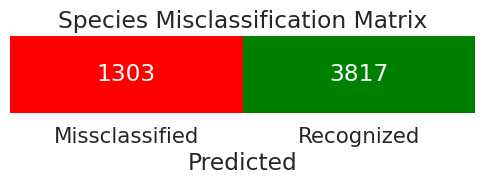

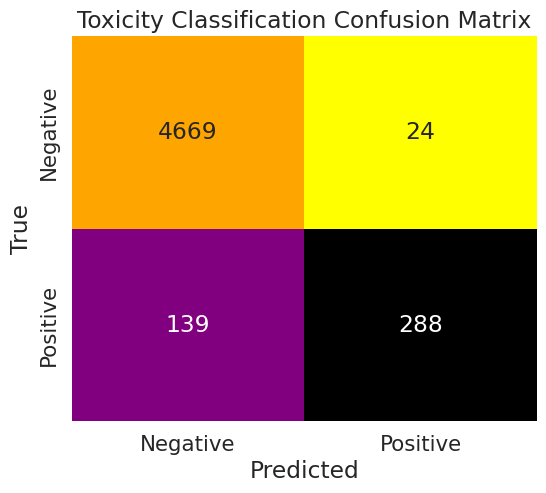


Epoch 2/4
Train Batch 1/322: Loss = 0.1034, Species Acc = 95.31%, Toxicity Acc = 100.00%
Train Batch 2/322: Loss = 0.0623, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 3/322: Loss = 0.0578, Species Acc = 96.88%, Toxicity Acc = 100.00%
Train Batch 4/322: Loss = 0.1471, Species Acc = 96.88%, Toxicity Acc = 100.00%
Train Batch 5/322: Loss = 0.0260, Species Acc = 100.00%, Toxicity Acc = 98.44%
Train Batch 6/322: Loss = 0.0539, Species Acc = 96.88%, Toxicity Acc = 98.44%
Train Batch 7/322: Loss = 0.0806, Species Acc = 93.75%, Toxicity Acc = 100.00%
Train Batch 8/322: Loss = 0.0648, Species Acc = 96.88%, Toxicity Acc = 100.00%
Train Batch 9/322: Loss = 0.0137, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 10/322: Loss = 0.0532, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 11/322: Loss = 0.1359, Species Acc = 96.88%, Toxicity Acc = 100.00%
Train Batch 12/322: Loss = 0.0146, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 13/322: Loss = 0.1098, Sp

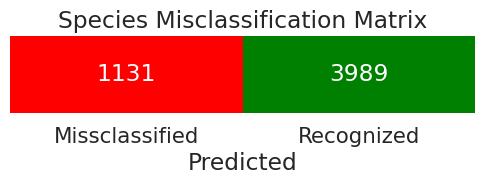

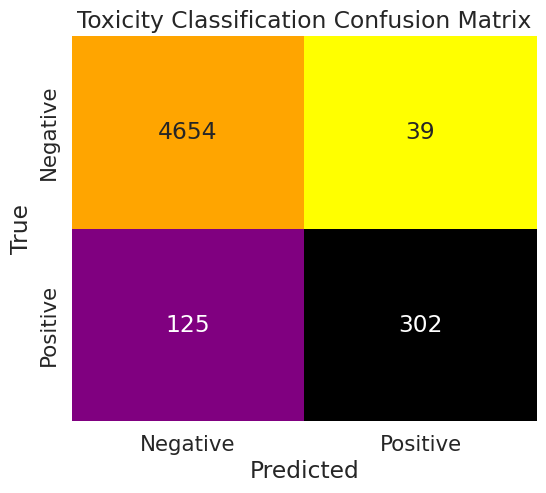


Epoch 3/4
Train Batch 1/322: Loss = 0.0306, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 2/322: Loss = 0.2023, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 3/322: Loss = 0.0019, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 4/322: Loss = 0.0074, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 5/322: Loss = 0.0169, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 6/322: Loss = 0.1751, Species Acc = 96.88%, Toxicity Acc = 100.00%
Train Batch 7/322: Loss = 0.0513, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 8/322: Loss = 0.1710, Species Acc = 96.88%, Toxicity Acc = 100.00%
Train Batch 9/322: Loss = 0.0348, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 10/322: Loss = 0.0306, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 11/322: Loss = 0.0377, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 12/322: Loss = 0.0646, Species Acc = 96.88%, Toxicity Acc = 100.00%
Train Batch 13/322: Loss = 0.0427, S

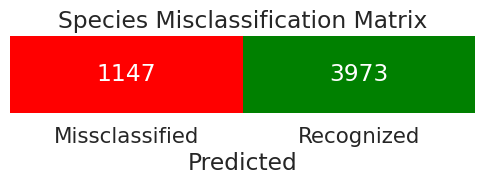

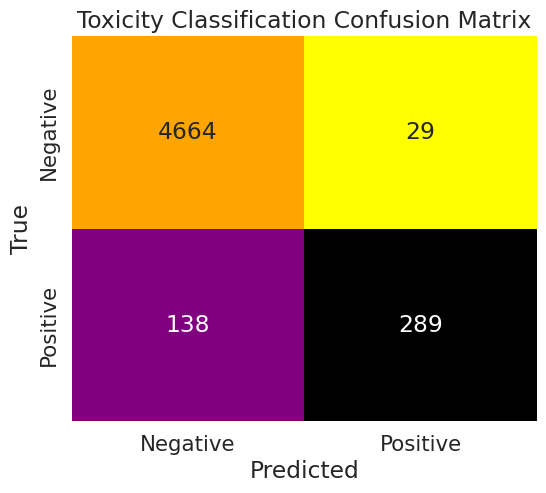


Epoch 4/4
Train Batch 1/322: Loss = 0.0327, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 2/322: Loss = 0.0164, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 3/322: Loss = 0.0014, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 4/322: Loss = 0.0113, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 5/322: Loss = 0.0037, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 6/322: Loss = 0.0081, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 7/322: Loss = 0.0027, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 8/322: Loss = 0.0134, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 9/322: Loss = 0.0005, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 10/322: Loss = 0.0118, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 11/322: Loss = 0.0140, Species Acc = 98.44%, Toxicity Acc = 100.00%
Train Batch 12/322: Loss = 0.0047, Species Acc = 100.00%, Toxicity Acc = 100.00%
Train Batch 13/322: Loss = 0

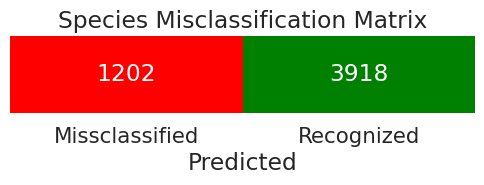

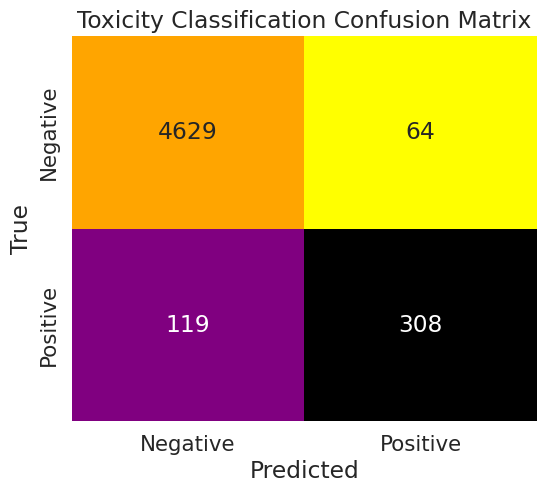

Training completed!


In [39]:
# Start training
training_stats = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model and statistics
torch.save(model.state_dict(), "multi_task_model.pth")
print("Training completed!")

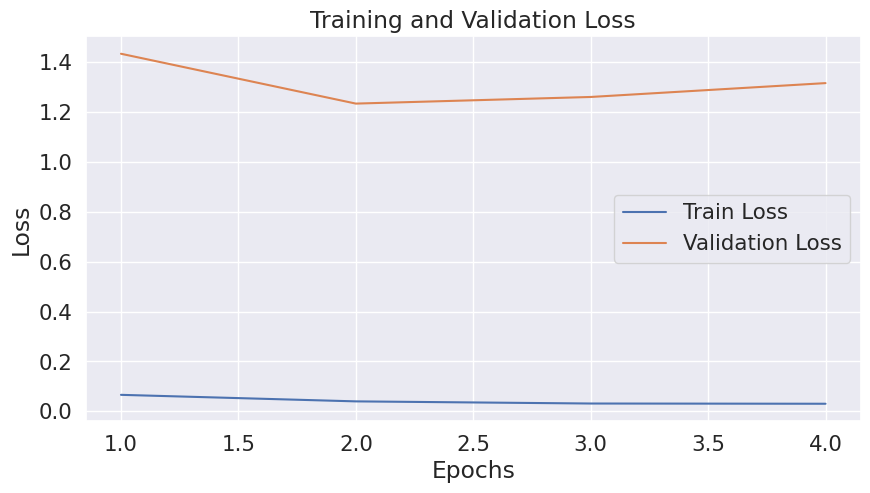

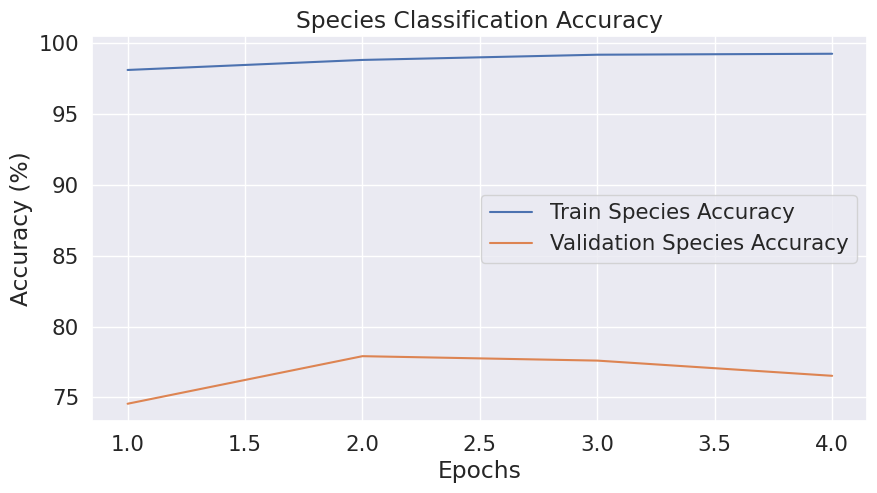

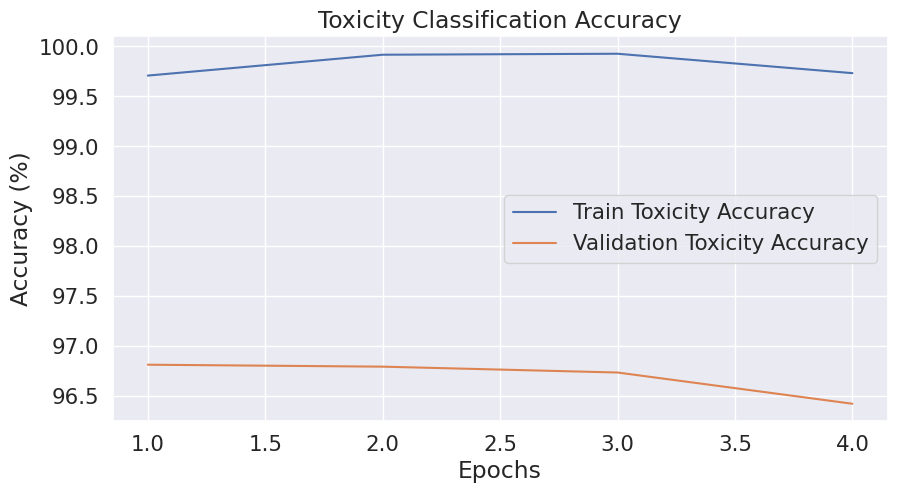

In [40]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_stats['train_losses'], label="Train Loss")
plt.plot(range(1, num_epochs + 1), training_stats['val_losses'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Species Classification Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_stats['train_accuracies_species'], label="Train Species Accuracy")
plt.plot(range(1, num_epochs + 1), training_stats['val_accuracies_species'], label="Validation Species Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Species Classification Accuracy")
plt.legend()
plt.show()

# Plot Toxicity Classification Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_stats['train_accuracies_toxicity'], label="Train Toxicity Accuracy")
plt.plot(range(1, num_epochs + 1), training_stats['val_accuracies_toxicity'], label="Validation Toxicity Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Toxicity Classification Accuracy")
plt.legend()
plt.show()

In [41]:
# Plot User-Focused Loss (if included)
if 'val_user_focused_losses' in training_stats:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), training_stats['val_user_focused_losses'], label="Validation User-Focused Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Validation User-Focused Loss")
    plt.legend()
    plt.show()